In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set(font_scale = 1.3)

# Exploratory Data Analysis

## Import data

In [12]:
# Data is in csv format
data = pd.read_csv("train.csv")
data.head()

,Patient Id,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Patient First Name,Family Name,Father's name,...,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Genetic Disorder,Disorder Subclass
0,PID0x6418,2.0,Yes,No,Yes,No,4.760603,Richard,NaN,Larre,...,NaN,9.857562,NaN,1.0,1.0,1.0,1.0,1.0,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy
1,PID0x25d5,4.0,Yes,Yes,No,No,4.910669,Mike,NaN,Brycen,...,Multiple,5.522560,normal,1.0,NaN,1.0,1.0,0.0,NaN,Cystic fibrosis
2,PID0x4a82,6.0,Yes,No,No,No,4.893297,Kimberly,NaN,Nashon,...,Singular,NaN,normal,0.0,1.0,1.0,1.0,1.0,Multifactorial genetic inheritance disorders,Diabetes
3,PID0x4ac8,12.0,Yes,No,Yes,No,4.705280,Jeffery,Hoelscher,Aayaan,...,Singular,7.919321,inconclusive,0.0,0.0,1.0,0.0,0.0,Mitochondrial genetic inheritance disorders,Leigh syndrome
4,PID0x1bf7,11.0,Yes,No,NaN,Yes,4.720703,Johanna,Stutzman,Suave,...,Multiple,4.098210,NaN,0.0,0.0,0.0,0.0,NaN,Multifactorial genetic inheritance disorders,Cancer


Data contains 45 columns with 2 response variables, Genetic Disorder and Disorder Subclass.

In [13]:
data.dtypes

Patient Id                                           object
Patient Age                                         float64
Genes in mother's side                               object
Inherited from father                                object
Maternal gene                                        object
Paternal gene                                        object
Blood cell count (mcL)                              float64
Patient First Name                                   object
Family Name                                          object
Father's name                                        object
Mother's age                                        float64
Father's age                                        float64
Institute Name                                       object
Location of Institute                                object
Status                                               object
Respiratory Rate (breaths/min)                       object
Heart Rate (rates/min                   

## Clean and standardise data

In [15]:
data = pd.read_csv("train.csv")
print('Dimension of original data \t:', data.shape)

# Drop duplicates, if any, based on unique Patient Id
data = data.drop_duplicates(subset = "Patient Id")

# Drop rows with missing Disorder Subclass
data = data.dropna(axis = 0, how = 'any', subset = ["Disorder Subclass"])

# Fill ambiguous observations with missing values
data.replace(['Ambiguous', 'No record', 'Not available', 'Not applicable', '-'], np.nan, inplace = True)

# Convert numerical values to strings for better visualisation
data["No. of previous abortion"].replace({0: "0", 1: "1", 2: "2", 3: "3", 4: "4"}, inplace = True)

# Rename columns and standardise value formats
data.rename(columns = {"Patient Age": "Patient's age",
                       "Genes in mother's side": "Inherited from mother",
                       "Autopsy shows birth defect (if applicable)": "Autopsy shows birth defect",
                       "Blood cell count (mcL)": "Blood cell count (million/mcL)",
                       "White Blood cell count (thousand per microliter)": "White blood cell count (thousand/mcL)",
                       "Respiratory Rate (breaths/min)": "Respiratory rate (breaths/min)",
                       "Heart Rate (rates/min" : "Heart rate (beats/min)",
                       "History of anomalies in previous pregnancies": "H/O anomalies in previous pregnancies",
                       "No. of previous abortion": "No. of previous abortions"},
                  inplace = True)
data['Autopsy shows birth defect'].replace('None', 'No', inplace = True)
data["Blood test result"] = data["Blood test result"].str.capitalize()

# Fill missing values in Genetic Disorder based on Disorder Subclass
for x in data[data['Genetic Disorder'].isnull() == False]:
    subclass_dict = data.set_index('Disorder Subclass')['Genetic Disorder'].to_dict()
    
    subclass_dict["Leigh syndrome"] = "Mitochondrial genetic inheritance disorders"
    subclass_dict["Cancer"] = "Multifactorial genetic inheritance disorders"
    subclass_dict["Alzheimer's"] = "Multifactorial genetic inheritance disorders"
    
    data["Genetic Disorder"] = data['Disorder Subclass'].apply(lambda x: subclass_dict.get(x))

# Shorten Genetic Disorder values for better visualisation
data["Genetic Disorder"].replace(["Mitochondrial genetic inheritance disorders", "Multifactorial genetic inheritance disorders",
                                  "Single-gene inheritance diseases"], ["Mitochondrial", "Multifactorial", "Single-gene"],
                                    inplace = True)

print('Dimension of new data \t\t:', data.shape)

Dimension of original data 	: (22083, 45)
Dimension of new data 		: (19915, 45)


Eliminated 2,168 missing values in Disorder Subclass

## Examine Test 1-5 variables

A group of variables named Test 1-5 do not seem to contribute to Genetic Disorder and Disorder Subclass.

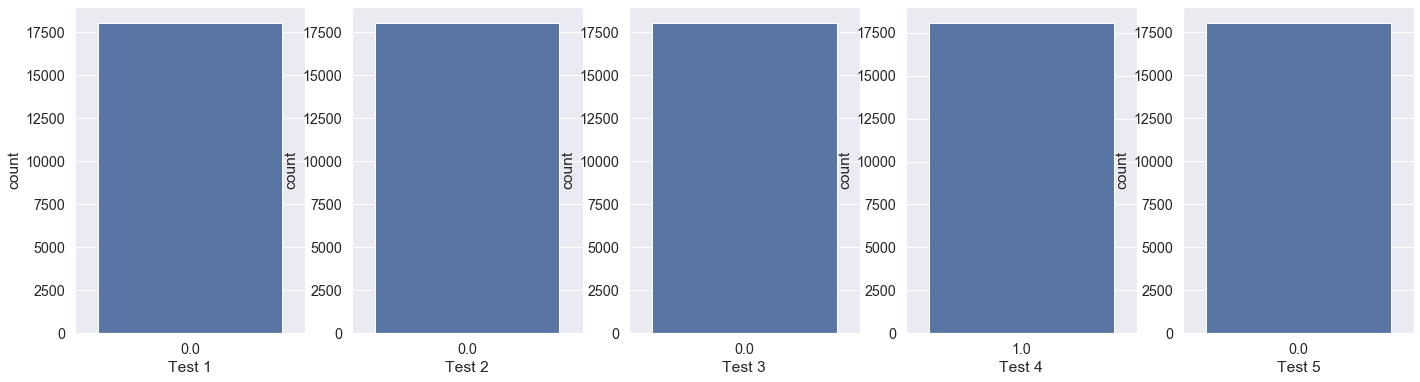

In [37]:
f, axes = plt.subplots(1, 5, figsize = (24, 6))

count = 0
for column in ["Test 1", "Test 2", "Test 3", "Test 4", "Test 5"]:
    full_data = clean_data.dropna(subset = [column], axis = 0, how = "any")
    sb.countplot(data = full_data, x = column, ax = axes[count])
    count += 1

Indeed, Test 1, 2, 3 and 5 have uniform 0.0 values for all observations, Test 4 contains only 1.0. These variables are ambiguous and most probably have no impact on classification.

## Drop columns irrelevant to classification

In [16]:
# Drop irrelevant columns including names, locations and Test 1-5 variables
drop_columns = ["Patient Id", "Patient First Name", "Family Name", "Father's name", "Institute Name", "Location of Institute",
                "Test 1", "Test 2", "Test 3", "Test 4", "Test 5", "Parental consent", "Place of birth"]
data = data.drop(drop_columns, axis = 1)

## Special treatment for Symptom 1-5 variables

A group of unspecified variables called Symptom 1-5, unlike Test 1-5, might have an impact on classification.

In [17]:
# Save a version with numerical Symptoms for a later section involving addition
num_symptom_data = data.copy() 

data[["Symptom 1", "Symptom 2", "Symptom 3", "Symptom 4", "Symptom 5"]] = data[["Symptom 1", "Symptom 2", "Symptom 3", "Symptom 4", "Symptom 5"]].astype("object")
# Convert numerical values into meaningful strings for visualisation
data["Symptom 1"].replace({0: "No", 1: "Yes"}, inplace = True)
data["Symptom 2"].replace({0: "No", 1: "Yes"}, inplace = True)
data["Symptom 3"].replace({0: "No", 1: "Yes"}, inplace = True)
data["Symptom 4"].replace({0: "No", 1: "Yes"}, inplace = True)
data["Symptom 5"].replace({0: "No", 1: "Yes"}, inplace = True)

clean_data = data.copy()
print('Dimension of new data \t\t:', clean_data.shape)

Dimension of new data 		: (19915, 32)


Left with 32 columns including 2 response variables.

In [6]:
clean_data.head()

,Patient's age,Inherited from mother,Inherited from father,Maternal gene,Paternal gene,Blood cell count (million/mcL),Mother's age,Father's age,Status,Respiratory rate (breaths/min),...,Birth defects,White blood cell count (thousand/mcL),Blood test result,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Genetic Disorder,Disorder Subclass
0,2.0,Yes,No,Yes,No,4.760603,NaN,NaN,Alive,Normal (30-60),...,NaN,9.857562,NaN,Yes,Yes,Yes,Yes,Yes,Mitochondrial,Leber's hereditary optic neuropathy
1,4.0,Yes,Yes,No,No,4.910669,NaN,23.0,Deceased,Tachypnea,...,Multiple,5.522560,Normal,Yes,NaN,Yes,Yes,No,Single-gene,Cystic fibrosis
2,6.0,Yes,No,No,No,4.893297,41.0,22.0,Alive,Normal (30-60),...,Singular,NaN,Normal,No,Yes,Yes,Yes,Yes,Multifactorial,Diabetes
3,12.0,Yes,No,Yes,No,4.705280,21.0,NaN,Deceased,Tachypnea,...,Singular,7.919321,Inconclusive,No,No,Yes,No,No,Mitochondrial,Leigh syndrome
4,11.0,Yes,No,NaN,Yes,4.720703,32.0,NaN,Alive,Tachypnea,...,Multiple,4.098210,NaN,No,No,No,No,NaN,Multifactorial,Cancer


In [20]:
clean_data.dtypes

Patient's age                             float64
Inherited from mother                      object
Inherited from father                      object
Maternal gene                              object
Paternal gene                              object
Blood cell count (million/mcL)            float64
Mother's age                              float64
Father's age                              float64
Status                                     object
Respiratory rate (breaths/min)             object
Heart rate (beats/min)                     object
Follow-up                                  object
Gender                                     object
Birth asphyxia                             object
Autopsy shows birth defect                 object
Folic acid details (peri-conceptional)     object
H/O serious maternal illness               object
H/O radiation exposure (x-ray)             object
H/O substance abuse                        object
Assisted conception IVF/ART                object


Most variables are categorical, a few are numerical.

## Response variables

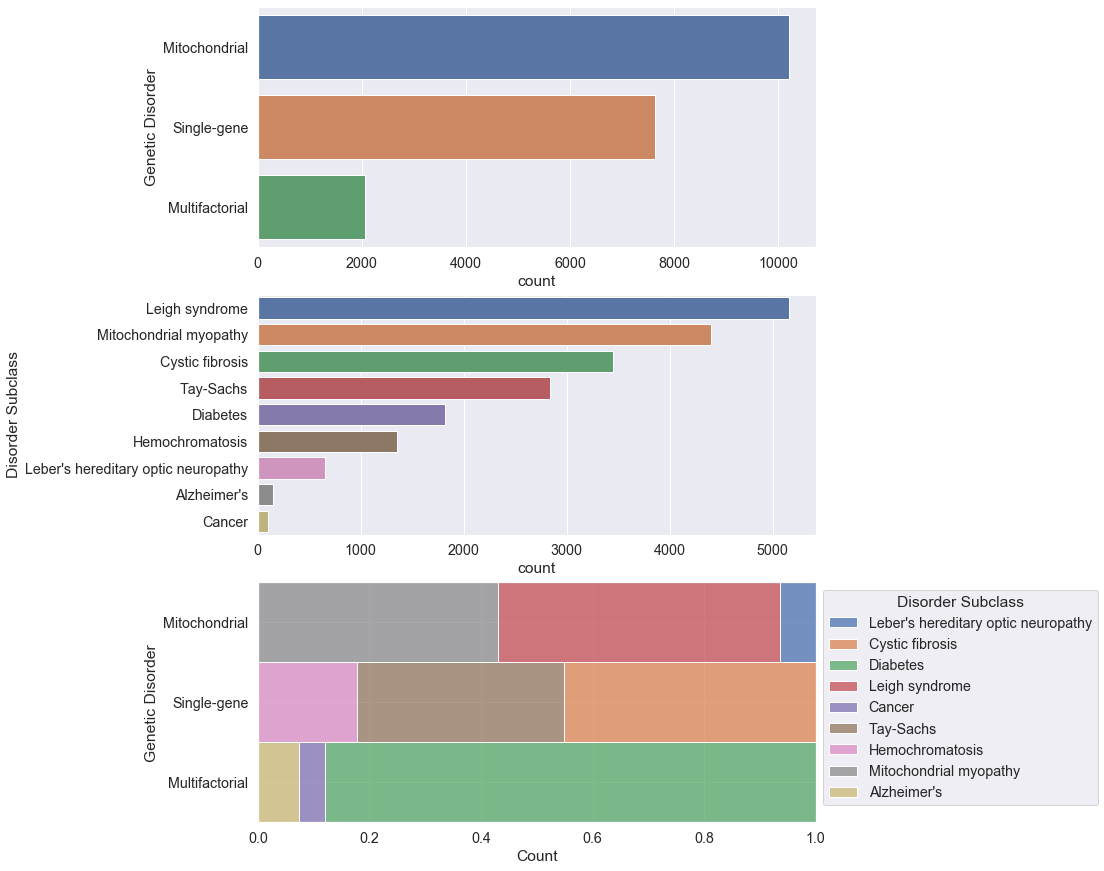

In [100]:
# Response variables

f, axes = plt.subplots(3, 1, figsize = (10, 15))
sb.countplot(data = clean_data, y = "Genetic Disorder", ax = axes[0])
sb.countplot(data = clean_data, y = "Disorder Subclass", order = clean_data["Disorder Subclass"].value_counts().index, ax = axes[1])
ax = sb.histplot(data = clean_data, y = "Genetic Disorder", stat = "count", hue = "Disorder Subclass", multiple = "fill", ax = axes[2])
sb.move_legend(ax, "upper left", bbox_to_anchor = (1, 1))

There is significant class imbalance in both Genetic Disorder classes and Disorder Subclass.

## Predictor variables

### Group variables by type of information

In [18]:
# Patient observations
patient_columns = ["Patient's age", "Gender", "Blood cell count (million/mcL)", "White blood cell count (thousand/mcL)",
                   "Blood test result", "Respiratory rate (breaths/min)", "Heart rate (beats/min)", "Follow-up", "Status",
                   "Symptom 1", "Symptom 2", "Symptom 3", "Symptom 4", "Symptom 5"]
birth_columns = ["Birth asphyxia", "Autopsy shows birth defect", "Birth defects", "Folic acid details (peri-conceptional)"]

# Inheritance factors
mother_columns = ["Mother's age", "Inherited from mother", "Maternal gene"]
father_columns = ["Father's age", "Inherited from father", "Paternal gene"]

# Mother's conditions
pregnancy_columns = ["Assisted conception IVF/ART", "H/O anomalies in previous pregnancies", "No. of previous abortions"]
mother_health_columns = ["H/O serious maternal illness", "H/O radiation exposure (x-ray)", "H/O substance abuse"]

### Create functions to plot graphs for visualisation

With regards to Genetic Disorder classes, each variable is presented with 3 plots.

Numerical variables are given:
(1) a boxpot distribution, 
(2) a histogram distribution with density plot, and 
(3) a violin distribution with respect to each of 3 Genetic Disorder classes

Categorical variables are presented with:
(1) an overall countplot showing unique value counts,
(2) a filled histogram plot showing proportion of Genetic Disorder classes within each unique value, and
(3) a filled histogram plot showing proportion of unique values within each Genetic Disorder class

With regards to Disorder Subclass, each variable is presented with 1 filled histogram that shows proportions of unique variables within each subclass.

In [19]:
# Function to plot distribution of Predictor variables in relation to Response variables

# With regards to Genetic Disorder, each variable is represented by 3 plots to show their distributions
def OverallDescription(column_list): # column_list refers list of columns as defined previously 
    for column in column_list:
        full_data = clean_data.dropna(subset = [column], axis = 0, how = "any")
        if full_data[column].dtypes == "float64":
            f, axes = plt.subplots(1, 3, figsize = (20, 4))
            sb.boxplot(data = full_data, x = column, ax = axes[0]) 
            sb.histplot(data = full_data, x = column, kde = True, ax = axes[1])
            sb.violinplot(data = full_data, y = column, x = "Genetic Disorder", ax = axes[2])
        if full_data[column].dtypes == "object":
            f, axes = plt.subplots(1, 3, figsize = (18, 4))
            sb.countplot(data = full_data, x = column, ax = axes[0])
            class1 = sb.histplot(data = full_data, x = column, stat = "count", hue = "Genetic Disorder", multiple = "fill", ax = axes[1])
            sb.move_legend(class1, "lower center", bbox_to_anchor = (0.5, 1))
            class2 = sb.histplot(data = full_data, x = "Genetic Disorder", stat = "count", hue = column, multiple = "fill", ax = axes[2])
            sb.move_legend(class2, "lower center", bbox_to_anchor = (0.5, 1))
            
# With regards to Disorder Subclass, each variable is presented by a filled histogram showing proportions of unique values within each subclass           
def SubclassDistribution(column_list):
    num_fig = len(column_list)
    length = 5*num_fig
    f, axes = plt.subplots(num_fig, 1, figsize = (10, length))

    count = 0
    for column in column_list:
        ax = sb.histplot(data = clean_data, y = "Disorder Subclass", stat = "count", hue = column, multiple = "fill", ax = axes[count])
        sb.move_legend(ax, "upper left", bbox_to_anchor = (1, 1))
        count += 1

## Patient observations

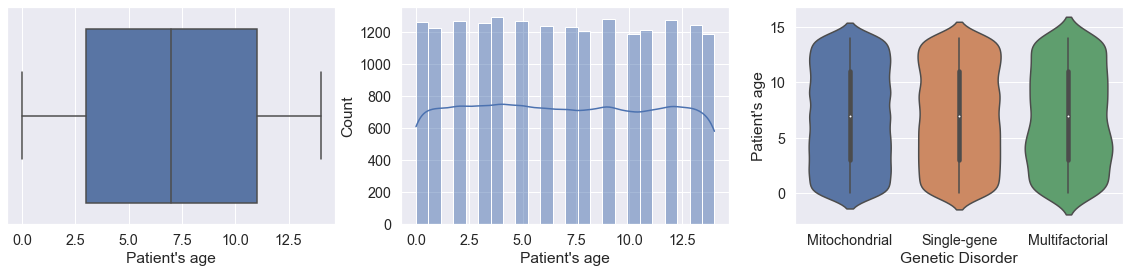

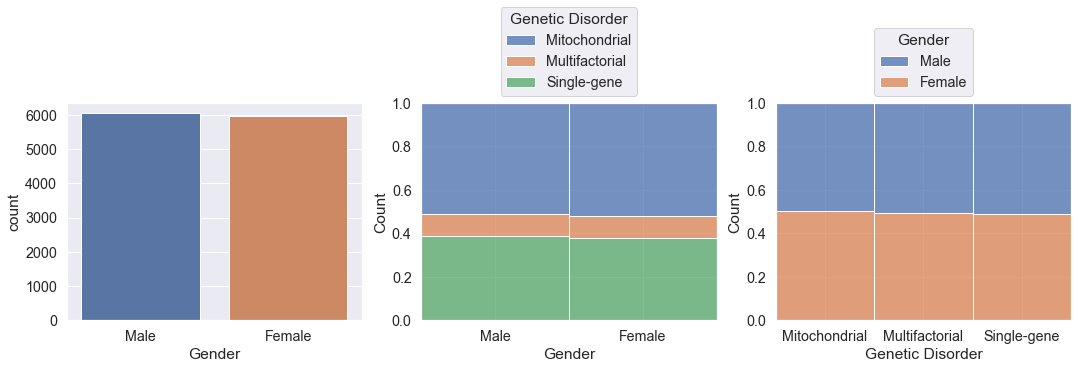

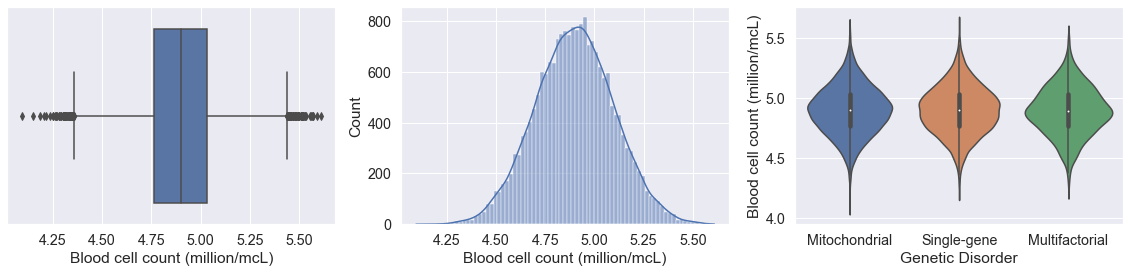

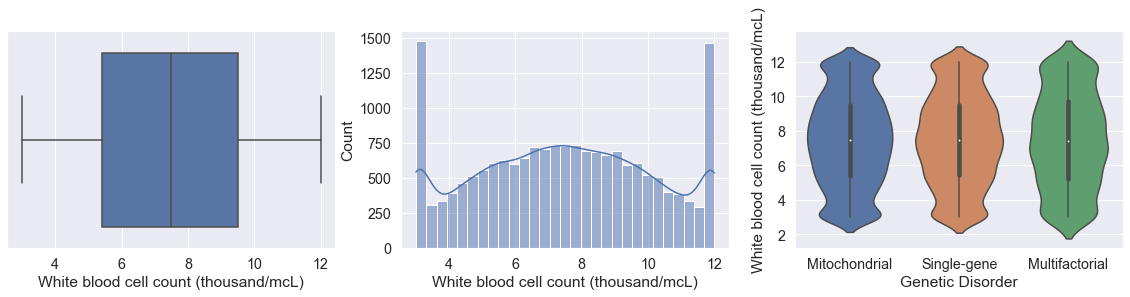

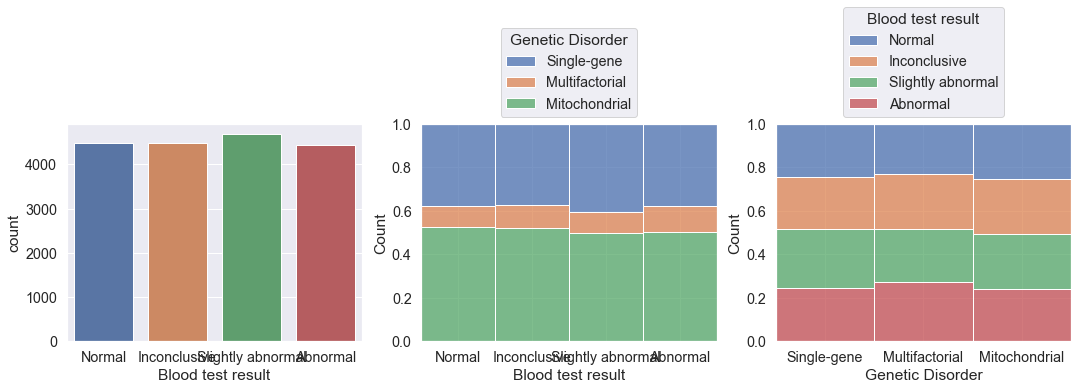

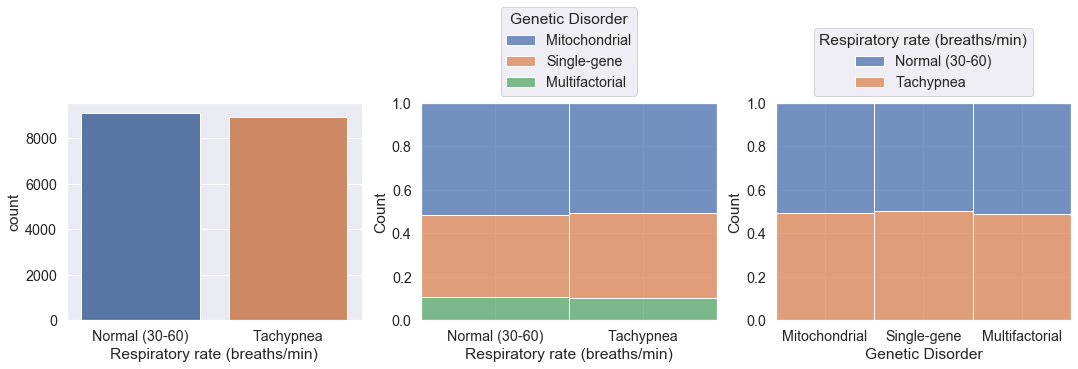

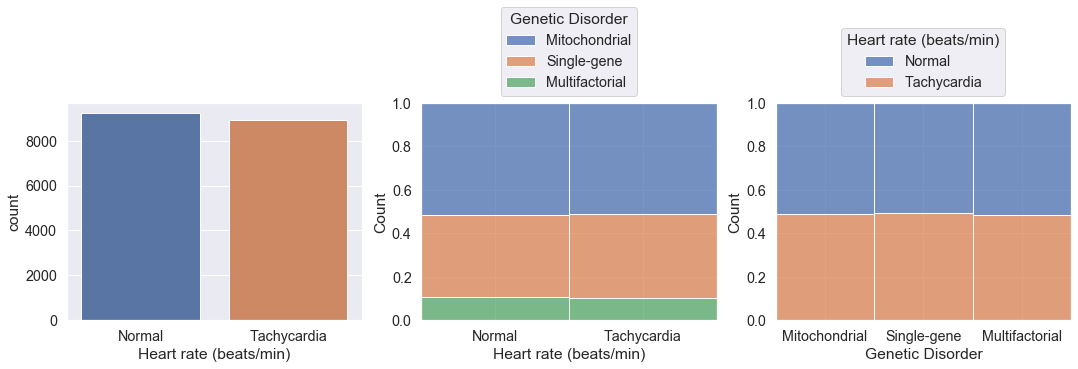

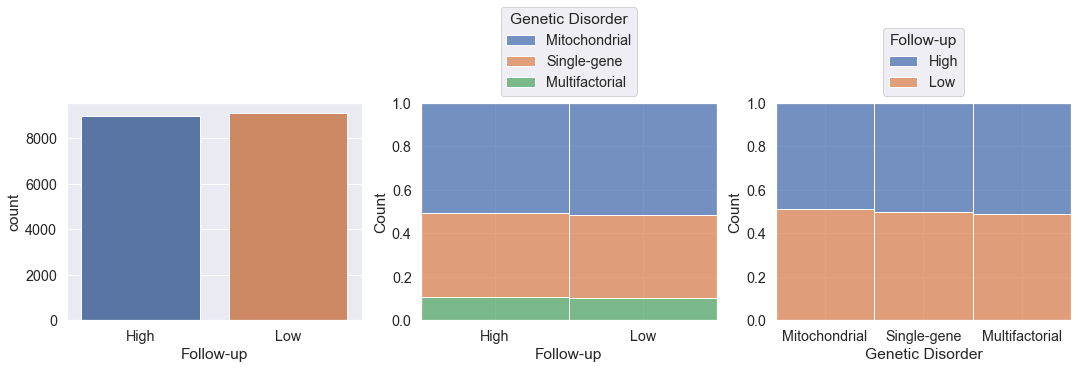

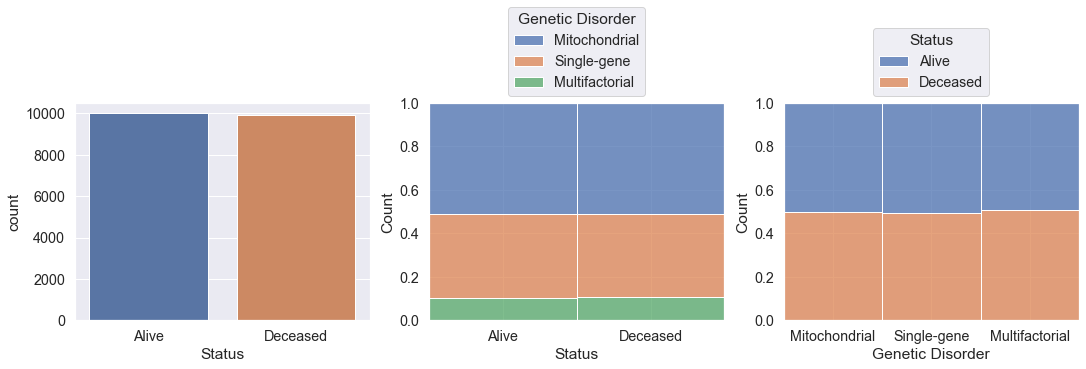

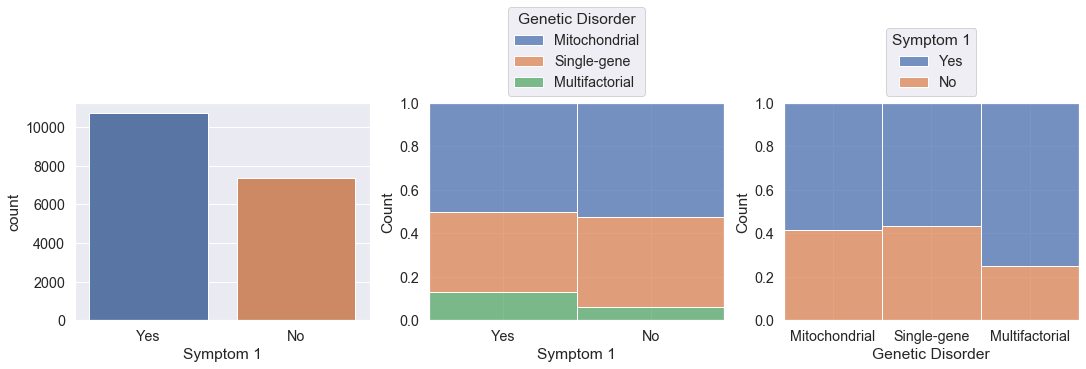

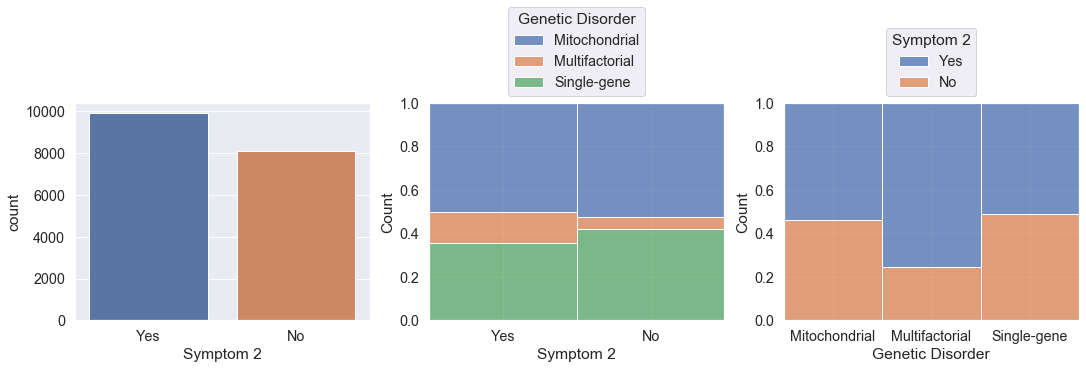

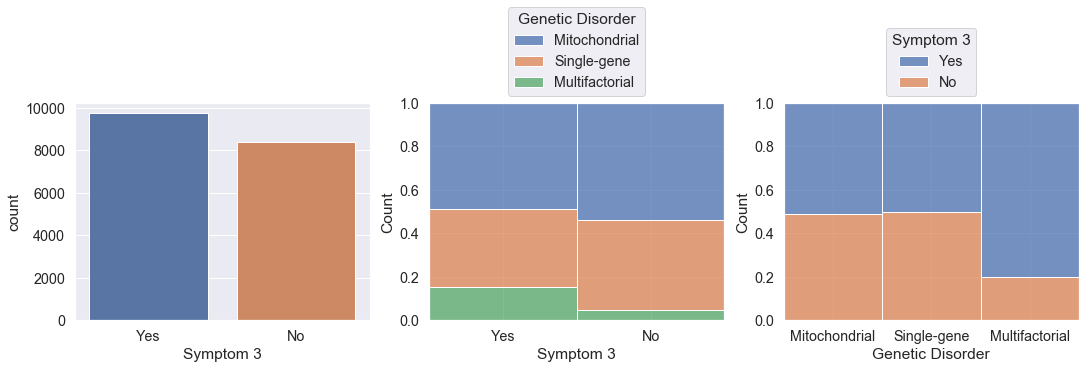

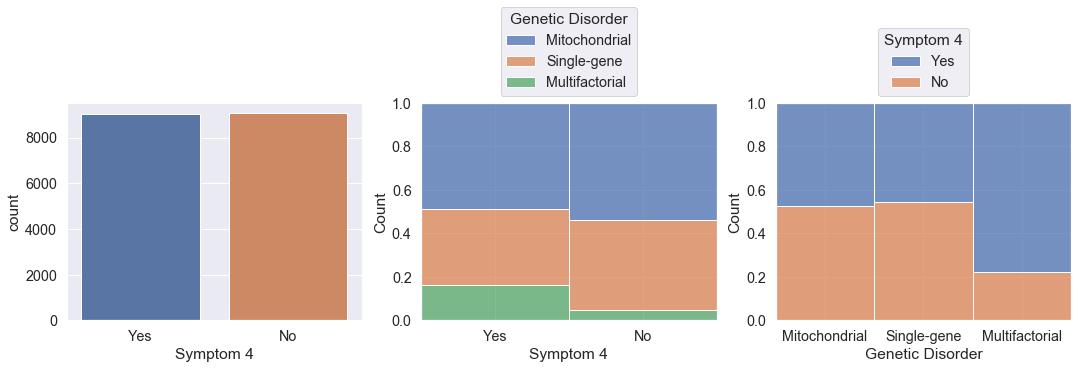

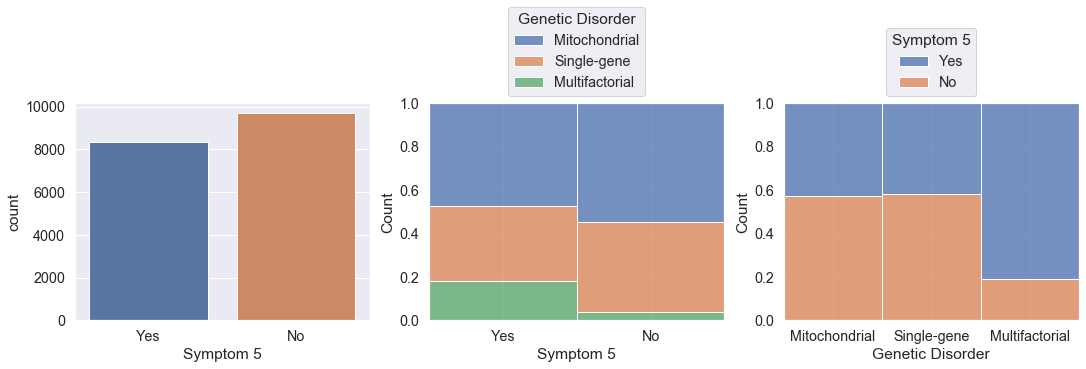

In [21]:
# Patient obervations - Genetic Disorder

OverallDescription(patient_columns)

Most variables are evenly distributed and are likely to have no impact on classification, except Symtoms 1-5.

## Symptom variables

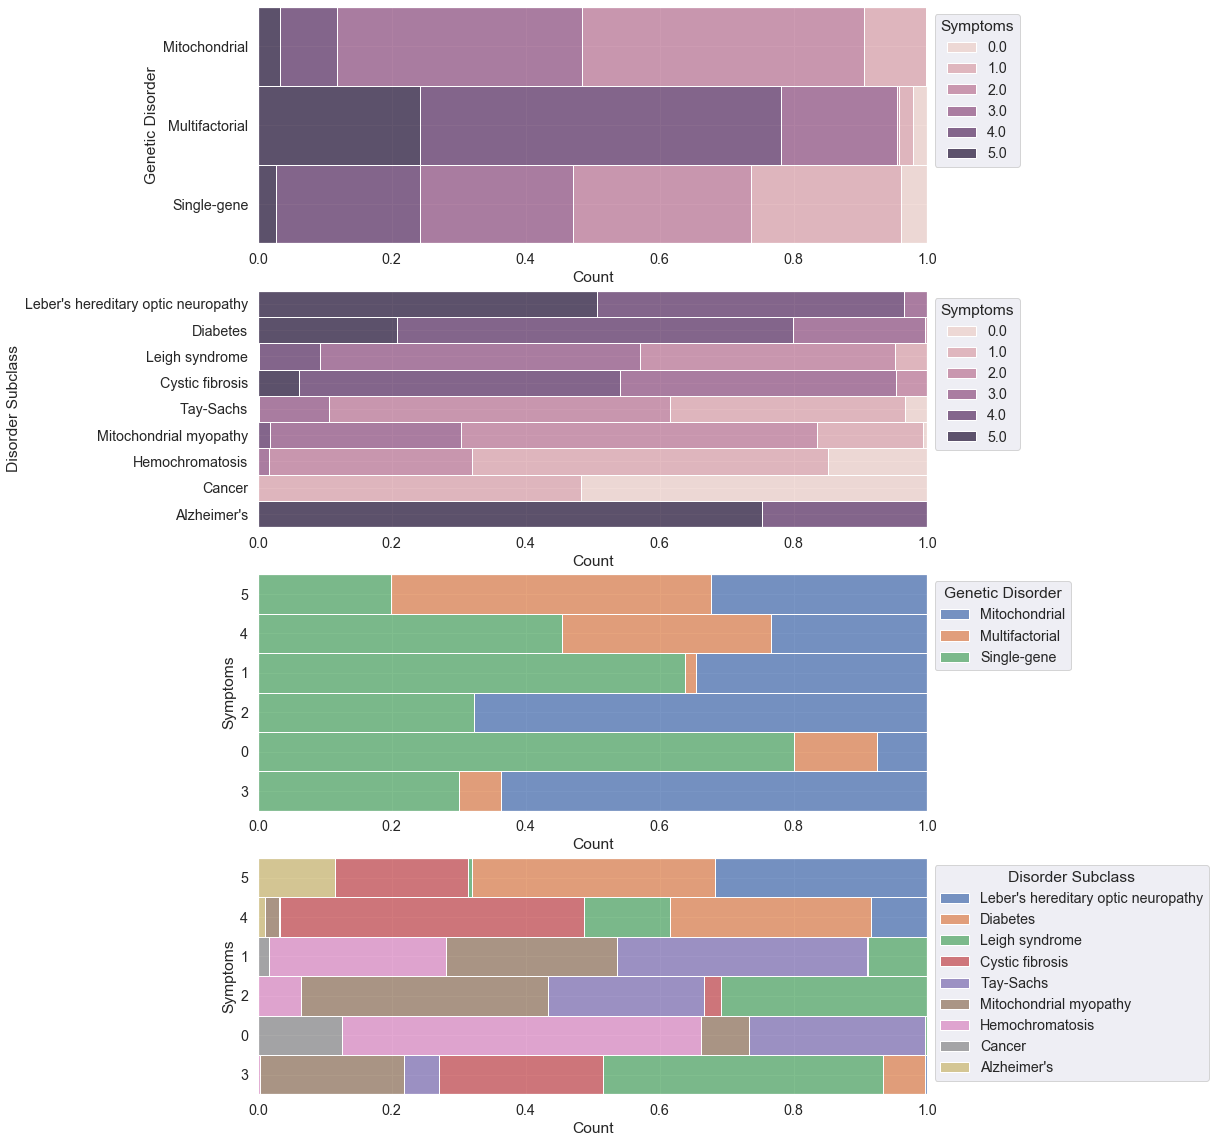

In [70]:
# Add sum of symptoms as new variable Symptoms
symptoms = num_symptom_data.dropna(subset = ["Symptom 1", "Symptom 2", "Symptom 3", "Symptom 4", "Symptom 5"], how = "any", axis = 0)
sum_symptoms = symptoms[["Symptom 1", "Symptom 2", "Symptom 3", "Symptom 4", "Symptom 5"]].sum(axis = 1)
symptoms = pd.concat([symptoms, sum_symptoms], axis = 1)
symptoms.rename(columns = {0: "Symptoms"}, inplace = True)
symptoms = symptoms.dropna(subset = ["Disorder Subclass"], how = "any", axis = 0)
symptoms["Symptoms"] = symptoms["Symptoms"].astype("object")

# Symptoms - Response
# Plot graphs of new variable Symptoms in relation to 2 response variables
f, axes = plt.subplots(4, 1, figsize = (12, 20))

# Filled histplot showing proportions of Symptoms within each class and subclass, and vice versa
ax1 = sb.histplot(data = symptoms, y = "Genetic Disorder", stat = "count", hue = "Symptoms", multiple = "fill", ax = axes[0])
sb.move_legend(ax1, "upper left", bbox_to_anchor = (1, 1))
ax2 = sb.histplot(data = symptoms, y = "Disorder Subclass", stat = "count", hue = "Symptoms", multiple = "fill", ax = axes[1])
sb.move_legend(ax2, "upper left", bbox_to_anchor = (1, 1))

symptoms["Symptoms"].replace({0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5"}, inplace = True)
ax3 = sb.histplot(data = symptoms, y = "Symptoms", stat = "count", hue = "Genetic Disorder", multiple = "fill", ax = axes[2])
sb.move_legend(ax3, "upper left", bbox_to_anchor = (1, 1))
ax4 = sb.histplot(data = symptoms, y = "Symptoms", stat = "count", hue = "Disorder Subclass", multiple = "fill", ax = axes[3])
sb.move_legend(ax4, "upper left", bbox_to_anchor = (1, 1))

Though individual symptoms are not helpful for classification, the sum of symptoms seem to impact classes and subclasses. For instance, patients with at least 3 symptoms are likely to have a multifactorial disorder, while patients at most 2 symptoms are more likely to have a mitochondrial or single-gene disorder.

With regards to subclasses, some more interesting observations can be made. Those showing fewer than 4 symptoms surely do not have Alzheimer's, and people with more than 1 symptom do not have cancer.

From the 3rd plot, patients showing no symptom are very likely to have a single-gene disorder. In contrast, those showing all symtoms are about 4 times less likely to have a single-gene disorder.

Lastly, we can see that about half of patients with no symptoms have Hemochromatosis, and when someone show all 5 symptoms, they are likely to have 1 of the 4 diseases Leber's, Diabetes, Cystic fibrosis, and Alzheimer's.

In short, the sum of symptoms can, to some extent, help us classify or at least narrow down what type of Genetic Disorders a patient has.

## Convert numerical variables to categorical ranges of values

From the distributions of Patient's age, Blood cell count, White blood cell count above, and later Mother's age and Father's age variable, we can see that these numerical variables tend to be evenly distributed among the observations. As a result, here we convert them into categorical variables made up of equal intervals of values to make simplify our classification models.

In [50]:
# Split all variables into equal intervals

# Patient's age
pa_edges = np.histogram_bin_edges(clean_data["Patient's age"].dropna(), bins = 5)
clean_data["Patient's age"] = pd.cut(clean_data["Patient's age"], bins = pa_edges, labels = [x for x in range(len(pa_edges) - 1)])

# Mother's age
ma_edges = np.histogram_bin_edges(clean_data["Mother's age"].dropna(), bins = 6)
clean_data["Mother's age"] = pd.cut(clean_data["Mother's age"], bins = ma_edges, labels = [x for x in range(len(ma_edges) - 1)])

# Father's age
fa_edges = np.histogram_bin_edges(clean_data["Father's age"].dropna(), bins = 6)
clean_data["Father's age"] = pd.cut(clean_data["Father's age"], bins = fa_edges, labels = [x for x in range(len(fa_edges) - 1)])  

# Blood cell count
bcc_edges = np.histogram_bin_edges(clean_data["Blood cell count (million/mcL)"].dropna(), bins = 4)
clean_data["Blood cell count (million/mcL)"] = pd.cut(clean_data["Blood cell count (million/mcL)"], bins = bcc_edges, labels = [x for x in range(len(bcc_edges) - 1)])

# White blood cell count
wbcc_edges = np.histogram_bin_edges(clean_data["White blood cell count (thousand/mcL)"].dropna(), bins = 4)
clean_data["White blood cell count (thousand/mcL)"] = pd.cut(clean_data["White blood cell count (thousand/mcL)"], bins = wbcc_edges, labels = [x for x in range(len(wbcc_edges) - 1)])

## Birth factors

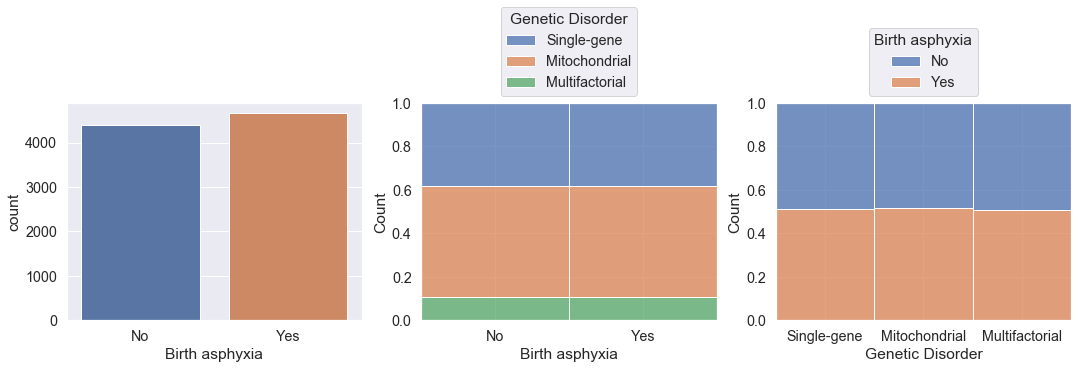

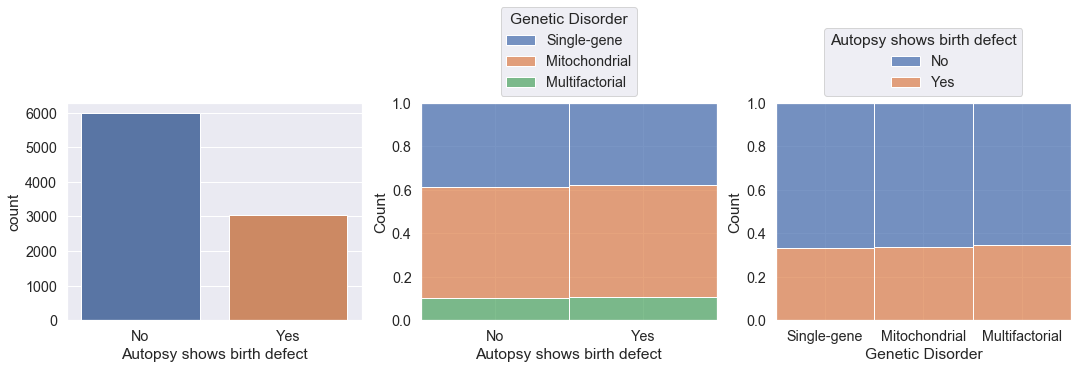

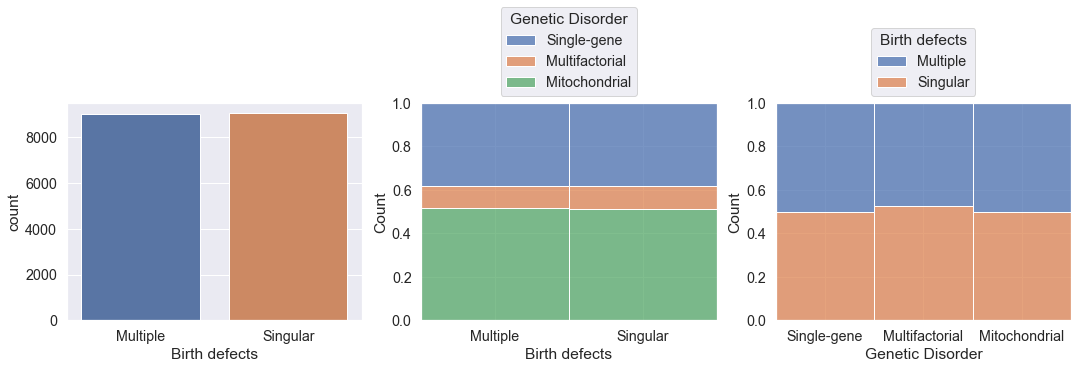

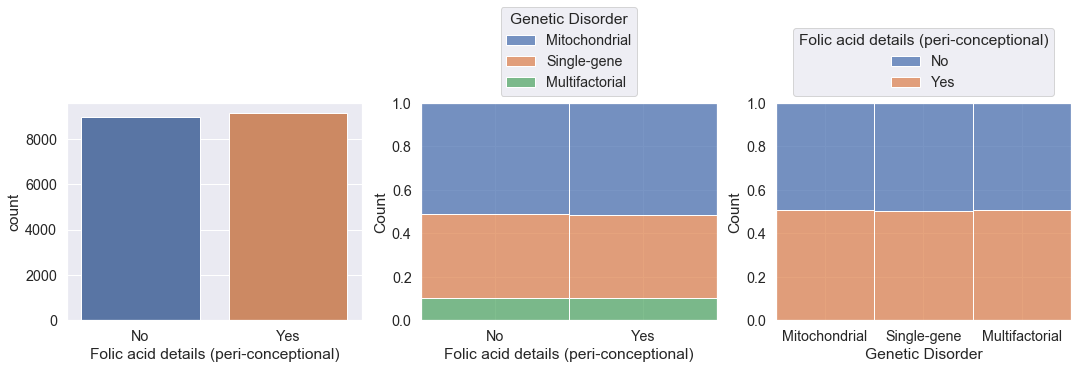

In [49]:
# Delivery-related variables
# Delivery - Genetic Disorder

OverallDescription(birth_columns)

Variables regarding information of the delivery do not seem to impact classification.

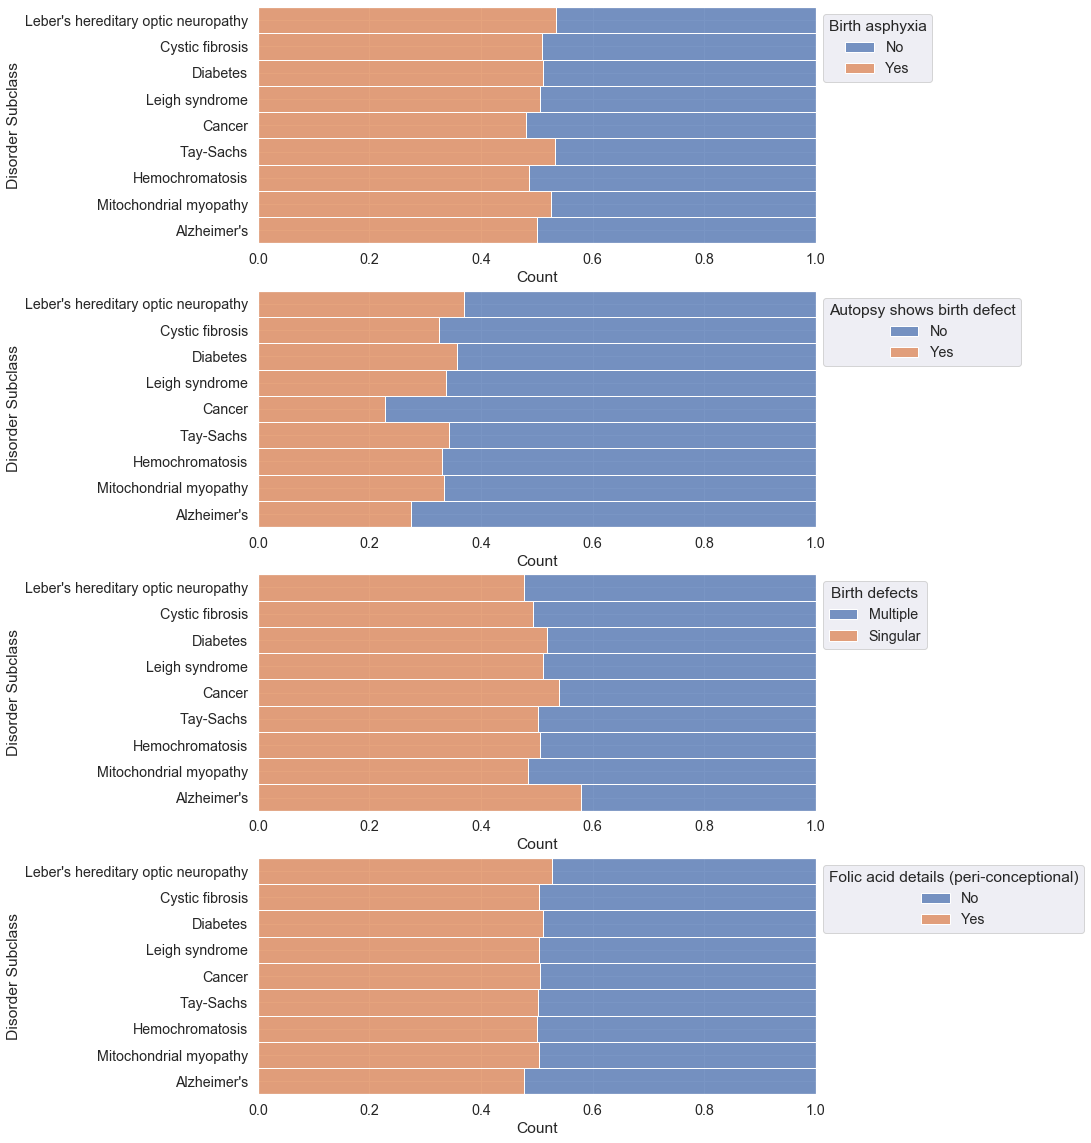

In [74]:
# Delivery - Disorder Subclass

SubclassDistribution(birth_columns)

Similarly, these variables show almost no impact on Disorder Subclasses as every disease has a 50-50 chance of showing Yes and No on these variables. A small exception is see in Cancer, where almost 80% of patients show no birth defects upon autoposy.

## Inheritance factors

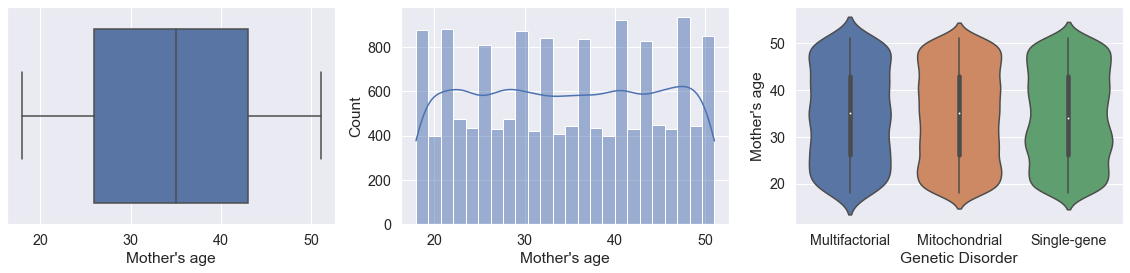

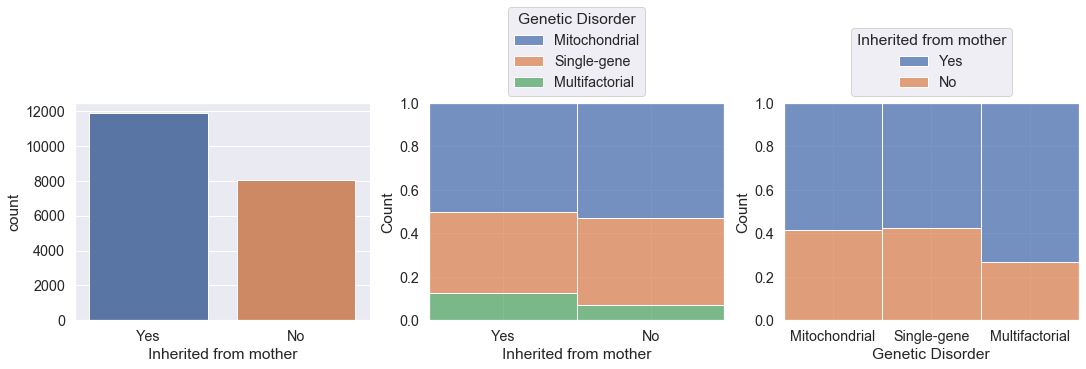

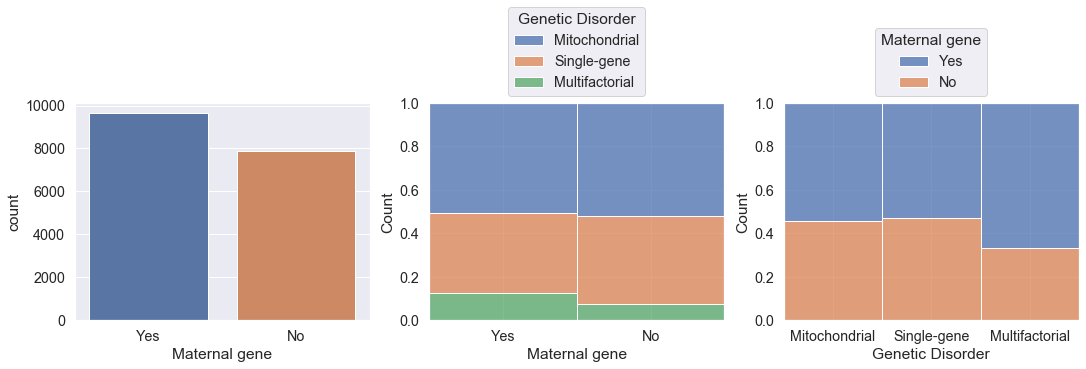

In [20]:
# Mother-related variables
# Mother - Gentetic Disorder

OverallDescription(mother_columns)

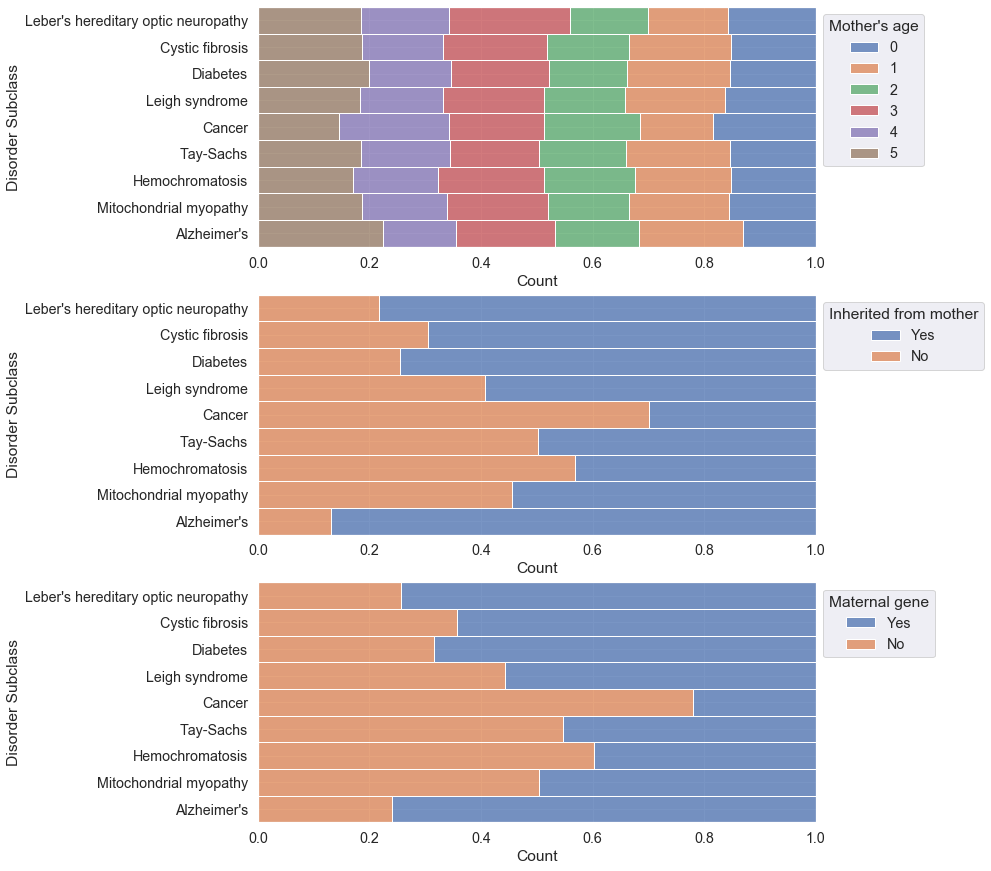

In [76]:
# Mother - Disorder Subclass

SubclassDistribution(mother_columns)

Mother-related information may have certain relationships with genetic disorders. This is expected as inheritance surely plays a part. Here, we assume that the varible Inherited from mother refers to the fact that the disease-causing gene is directly passed down from the mother to the patient, while the variable Maternal gene refers to whether the gene runs in the mother's family. Similar interpretations are to be made for parallel variables regarding the father.

Mother's age seems to have no effect. However, multifactorial disorders tend to be inherited from the mother. Among these multifactorial disorders, while almost 80% of Alzheimer's disease cases are inherited from the mother, the majority of Cancer cases are not.

Another thing to note is that there are similar trends in both classes and subclasses between Inherited from mother and Maternal gene, which makes perfect sense, since the disease-causing gene running in the family has to be at least carried by the mother (even if the mother is not affected by the disease) for the child to inherit it. In other words, as long as the gene is passed down from the mother, it is safe to assume the gene runs in the family, but not the other way around. As such, porportions of Yes tend to be larger for Inherited from mother than Maternal gene for all individual diseases.

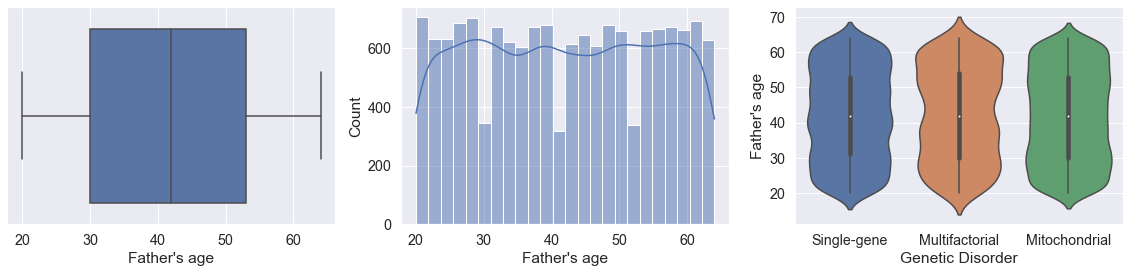

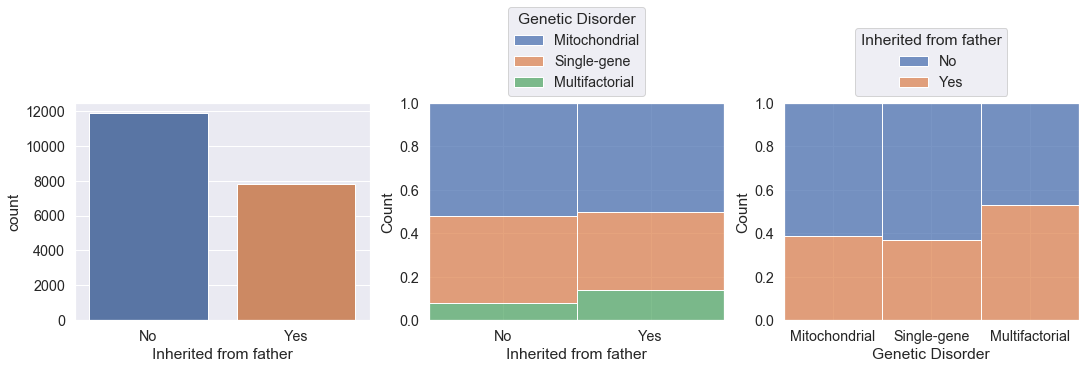

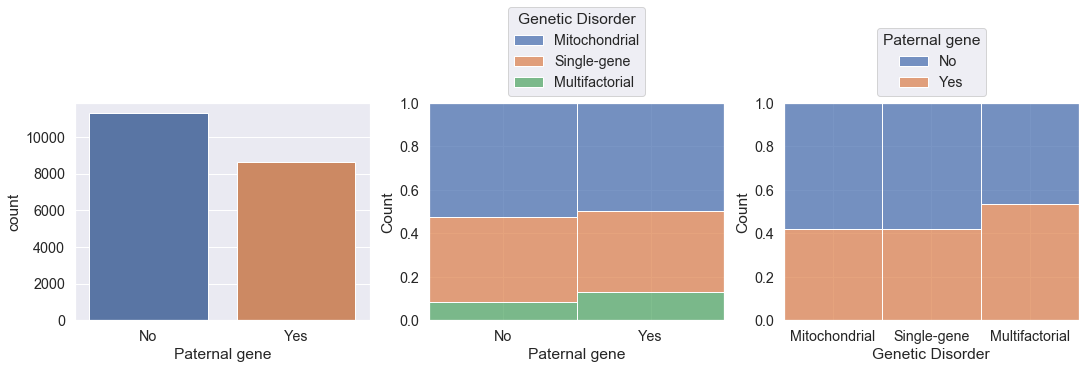

In [22]:
# Father-related variables
# Father - Gentetic Disorder

OverallDescription(father_columns)

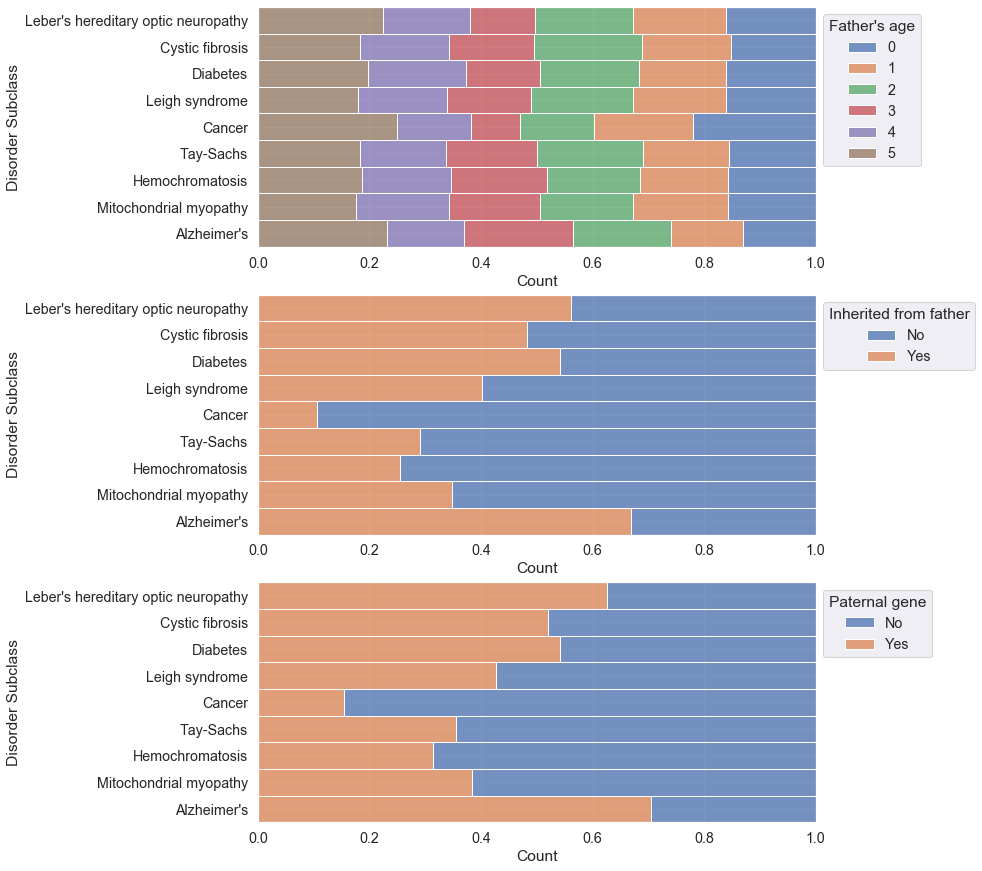

In [78]:
# Father - Disorder Subclass

SubclassDistribution(father_columns)

Similar observations can be made with variables regarding the father. Firstly, father's age seems to have no impact. Note that the colour code in these graphs is inverted. The majority of Alzheimer's patients still show inheritance from the father, while Cancer do not.

Cancer is a genetic disorder, but many a times mutations arise in the body throughout a person's lifetime - mutations that are not necessarily inherited from parents. Therefore, it looks like it is reasonable to see a lack of inheritance factors in these Cancer patients. However, cancers arising from non-germline mutations, that is, the cancer is not inherited, tend to manifest only later in life because it takes time for mutations to accumulate and eventually result in malignant tumours. In this dataset, we have patients of at most 14 years of age, which logically would suggest that any cancer they have is inherited. However, these plots show an opposite trend and it is interesting. These observations of course could still be non-representative because there are only 93 Cancer observations.

## Combine inheritance factors - Inherited from mother/father

Since trends are observed between mother's/father's information and genetic disorders, especially in multifactorial disorders, it might be helpful to examine the interplay between these variables. Clinically speaking, multifactorial disorders could include recessive hereditary diseases which require the disease-carrying genes from both parents to manifest in the child. Therefore, it is reasonable to see how these variables, combined, play a role in classifying genetic disorders.

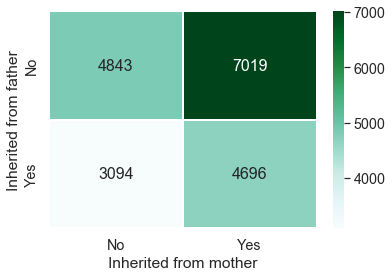

In [53]:
# Examine relationship between inheritance from mother and father

inheritance_data = clean_data.dropna(subset = ["Inherited from father", "Inherited from mother"], axis = 0, how = "any")
sb.heatmap(inheritance_data.groupby(["Inherited from father", "Inherited from mother"]).size().unstack(), 
           linewidths = 1, annot = True, annot_kws = {"size": 16}, cmap = "BuGn", fmt = "2g")

A large proportions of disorders are inherited from the mother alone. Roughly equal numbers are inherited from both parents or neither, and a smaller proportion is inherited from the father alone.

In [54]:
# Add Inheritance (inherited disorder from mother and/or father) column containing combined information on inheritance

inheritance = pd.DataFrame(inheritance_data.groupby(["Inherited from father", "Inherited from mother"]).ngroup(), columns = ["Inheritance"])
inheritance_data = pd.concat([inheritance_data, inheritance], axis = 1)
inheritance_data["Inheritance"] = inheritance_data["Inheritance"].astype("object")

# Replace group numbers with meaningly interpretations
inheritance_data["Inheritance"].replace([0, 1, 2, 3], ["Neither", "Mother only", "Father only", "Both"], inplace = True)

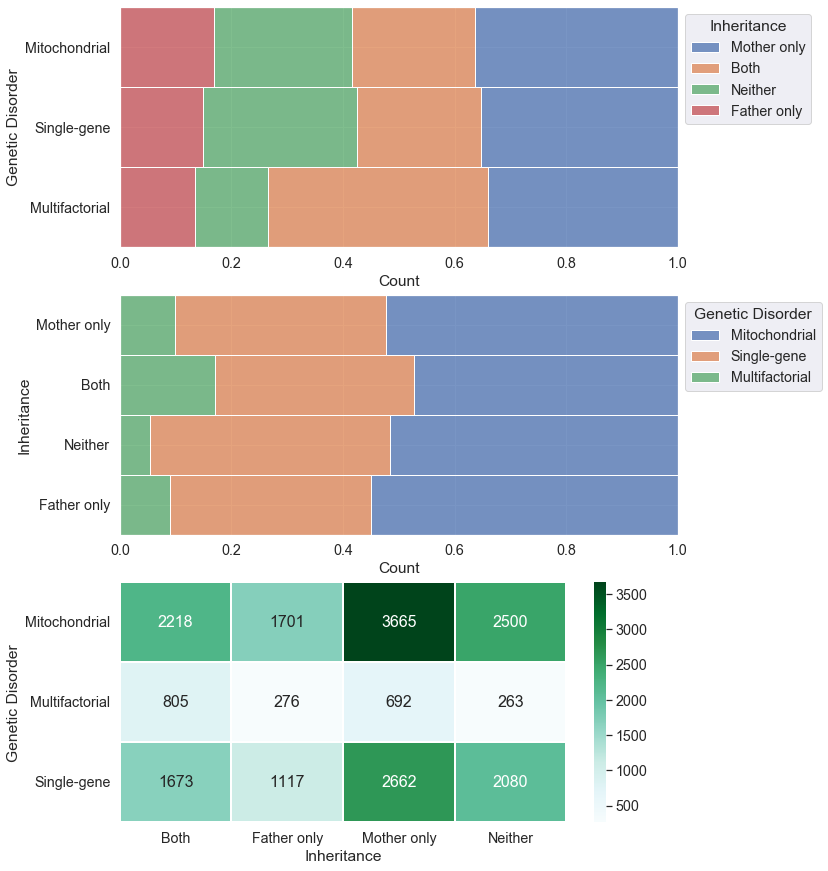

In [85]:
# Inheritance - Genetic Disorder

# Plot filled histograms and heatmap to show inheritance patterns among disorder classes and subclasses
f, axes = plt.subplots(3, 1, figsize = (10, 15))

ax1 = sb.histplot(data = inheritance_data, y = "Genetic Disorder", hue = "Inheritance", multiple = "fill", ax = axes[0])
sb.move_legend(ax1, "upper left", bbox_to_anchor = (1, 1))
ax2 = sb.histplot(data = inheritance_data, y = "Inheritance", hue = "Genetic Disorder", multiple = "fill", ax = axes[1])
sb.move_legend(ax2, "upper left", bbox_to_anchor = (1, 1))
sb.heatmap(inheritance_data.groupby(["Genetic Disorder", 'Inheritance']).size().unstack(), 
       linewidths = 1, annot = True, annot_kws = {"size": 16}, cmap = "BuGn", fmt = "2g", ax = axes[2])

In the first plot, due to the large number of diseases inherited only from the mother, they contribute to the largest proportions of all Genetic Disorder classes. Something to note here is that multifactorial disorders are way more likely to be inherited from the mother alone or from both parents. Inheritance from the mother accounts for almost 80% of multifactorial disorders. The patterns are similar and somewhat uniform among mitochondrial and single-gene disorders.

From the second plot, due to the overwhelming number of mitochondrial disorders in the dataset, it is expected they account for half of all inheritance patterns. Agreeing with the previous plot, the biggest proportion of multifactorial disorders (about 40%) are inherited from both parents, explaining why we previously saw many multifactorial disosrders being inherited from the mother and father separately.

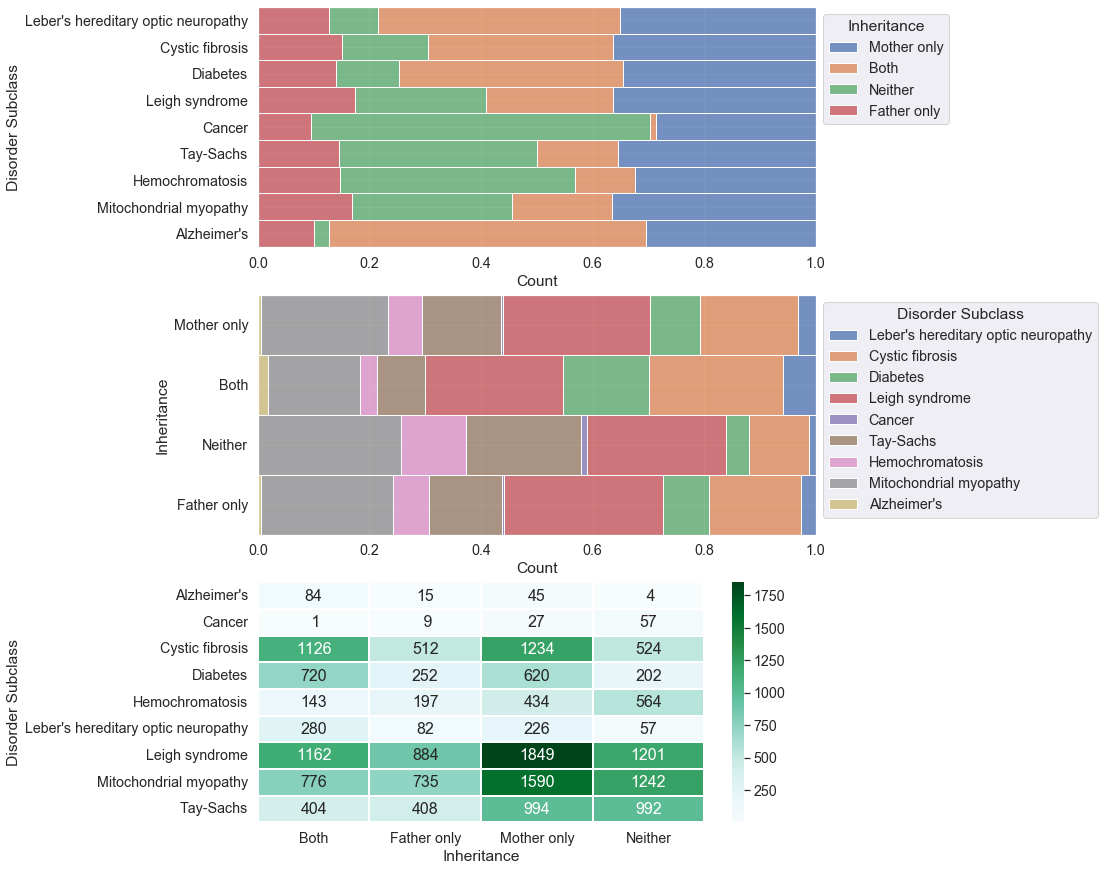

In [86]:
# Inheritance - Disorder Subclass

# Plot similar filled histograms and heatmap to show patterns in inheritance, this time among specific genetic diseases
f, axes = plt.subplots(3, 1, figsize = (10, 15))

ax1 = sb.histplot(data = inheritance_data, y = "Disorder Subclass", hue = "Inheritance", multiple = "fill", ax = axes[0])
sb.move_legend(ax1, "upper left", bbox_to_anchor = (1, 1))
ax2 = sb.histplot(data = inheritance_data, y = "Inheritance", hue = "Disorder Subclass", multiple = "fill", ax = axes[1])
sb.move_legend(ax2, "upper left", bbox_to_anchor = (1, 1))
sb.heatmap(inheritance_data.groupby(["Disorder Subclass", 'Inheritance']).size().unstack(), 
       linewidths = 1, annot = True, annot_kws = {"size": 16}, cmap = "BuGn", fmt = "2g", ax = axes[2])

Consistent with previous observations, most Alzheimer's cases are inherited from both parents, while most Cancers are inherited from neither. Alzheimer's disease is overwhelmingly controlled by inheritance from the mother. Leber's, Cystic fibrosis and Diabetes show similar patterns, though to a smaller extent.

## Repeat analysis for familial inheritance - Maternal/Paternal gene

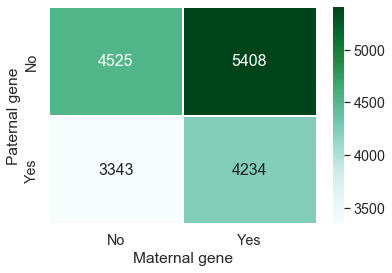

In [87]:
# Examine relationship between inheritance from maternal and paternal family

family_data = clean_data.dropna(subset = ["Paternal gene", "Maternal gene"], axis = 0, how = "any")
sb.heatmap(family_data.groupby(["Paternal gene", "Maternal gene"]).size().unstack(), 
           linewidths = 1, annot = True, annot_kws = {"size": 16}, cmap = "BuGn", fmt = "2g")

In [88]:
# Add Inheritance (inherited disorder from mother and/or father) column

family = pd.DataFrame(family_data.groupby(["Paternal gene", "Maternal gene"]).ngroup(), columns = ["Family gene"])
family_data = pd.concat([family_data, family], axis = 1)
family_data["Family gene"] = family_data["Family gene"].astype("object")
family_data["Family gene"].replace([0, 1, 2, 3], ["Neither", "Maternal only", "Paternal only", "Both"], inplace = True)

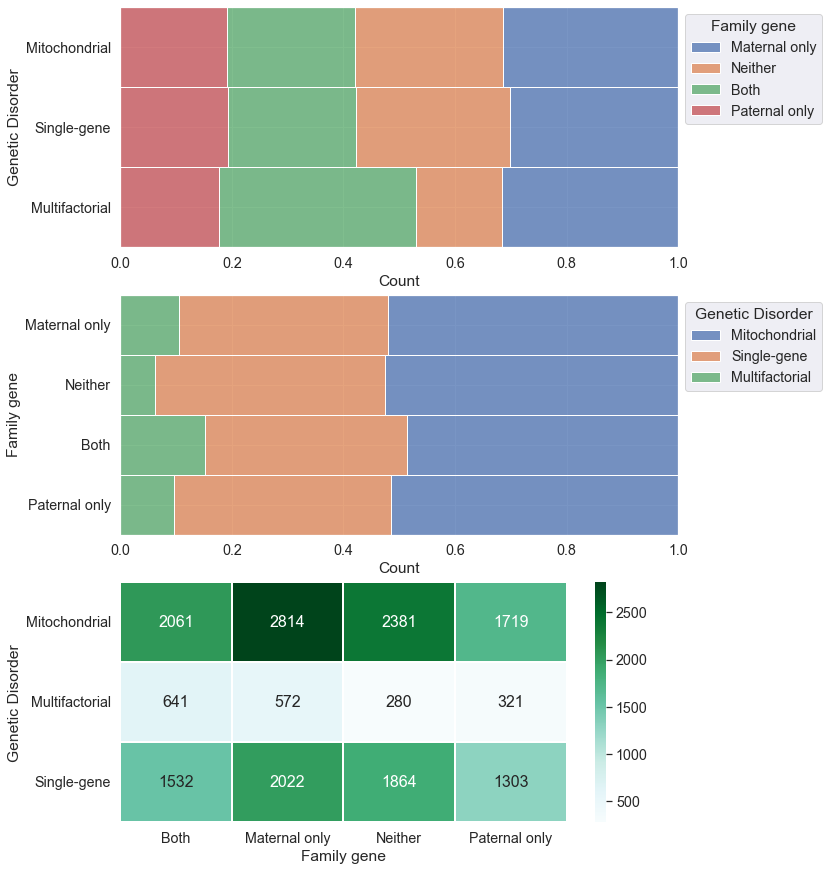

In [92]:
# Family - Genetic Disorder

f, axes = plt.subplots(3, 1, figsize = (10, 15))

ax1 = sb.histplot(data = family_data, y = "Genetic Disorder", hue = "Family gene", multiple = "fill", ax = axes[0])
sb.move_legend(ax1, "upper left", bbox_to_anchor = (1, 1))
ax2 = sb.histplot(data = family_data, y = "Family gene", hue = "Genetic Disorder", multiple = "fill", ax = axes[1])
sb.move_legend(ax2, "upper left", bbox_to_anchor = (1, 1))
sb.heatmap(family_data.groupby(["Genetic Disorder", "Family gene"]).size().unstack(), 
       linewidths = 1, annot = True, annot_kws = {"size": 16}, cmap = "BuGn", fmt = "2g", ax = axes[2])

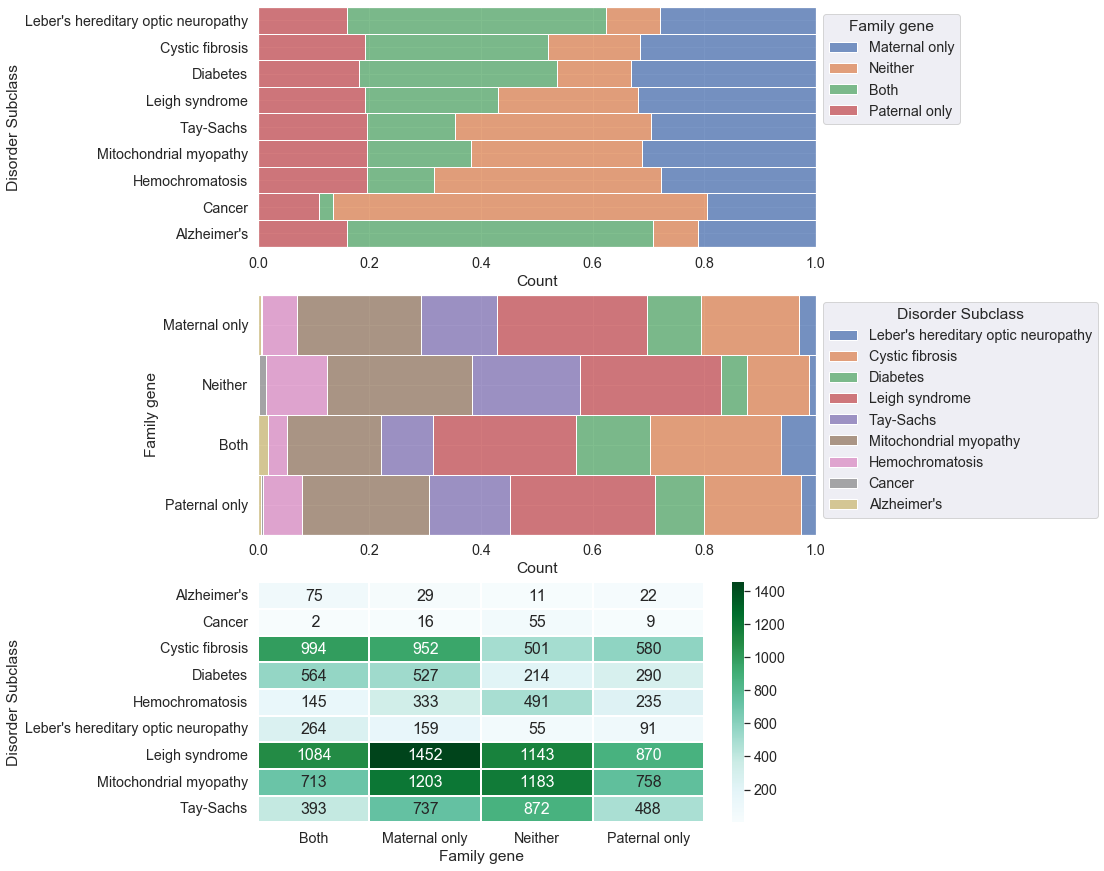

In [93]:
# Family - Disorder Subclass

f, axes = plt.subplots(3, 1, figsize = (10, 15))

ax1 = sb.histplot(data = family_data, y = "Disorder Subclass", hue = "Family gene", multiple = "fill", ax = axes[0])
sb.move_legend(ax1, "upper left", bbox_to_anchor = (1, 1))
ax2 = sb.histplot(data = family_data, y = "Family gene", hue = "Disorder Subclass", multiple = "fill", ax = axes[1])
sb.move_legend(ax2, "upper left", bbox_to_anchor = (1, 1))
sb.heatmap(family_data.groupby(["Disorder Subclass", "Family gene"]).size().unstack(), 
       linewidths = 1, annot = True, annot_kws = {"size": 16}, cmap = "BuGn", fmt = "2g", ax = axes[2])

Unsurprisingly, the same observations can be made for this pair of varibles. As explained above, diseases that are inherited from the parents are likely to run in their respective families. No new trends seem to emerge when we look at familial inheritance, so they are likely not as helpful as long as we already take into account parental inheritance.

## Pregnancy factors

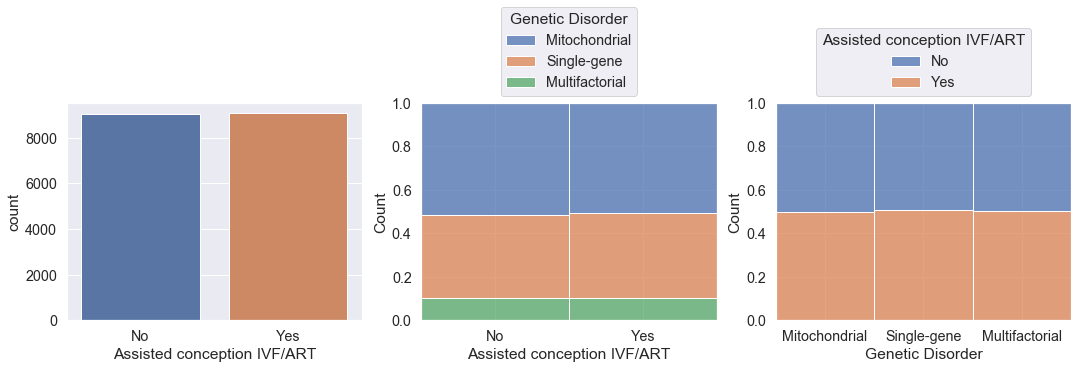

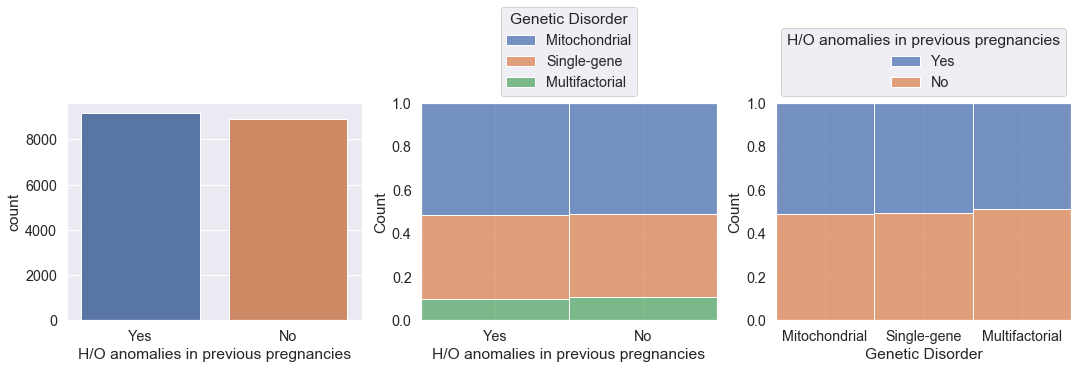

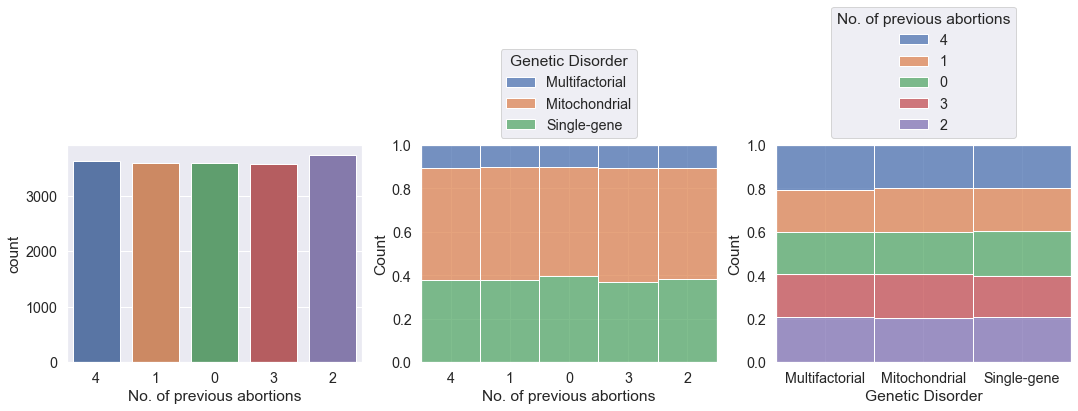

In [96]:
# Pregnancy-related variables
# Pregnancy - Genetic Disorder

OverallDescription(pregnancy_columns)

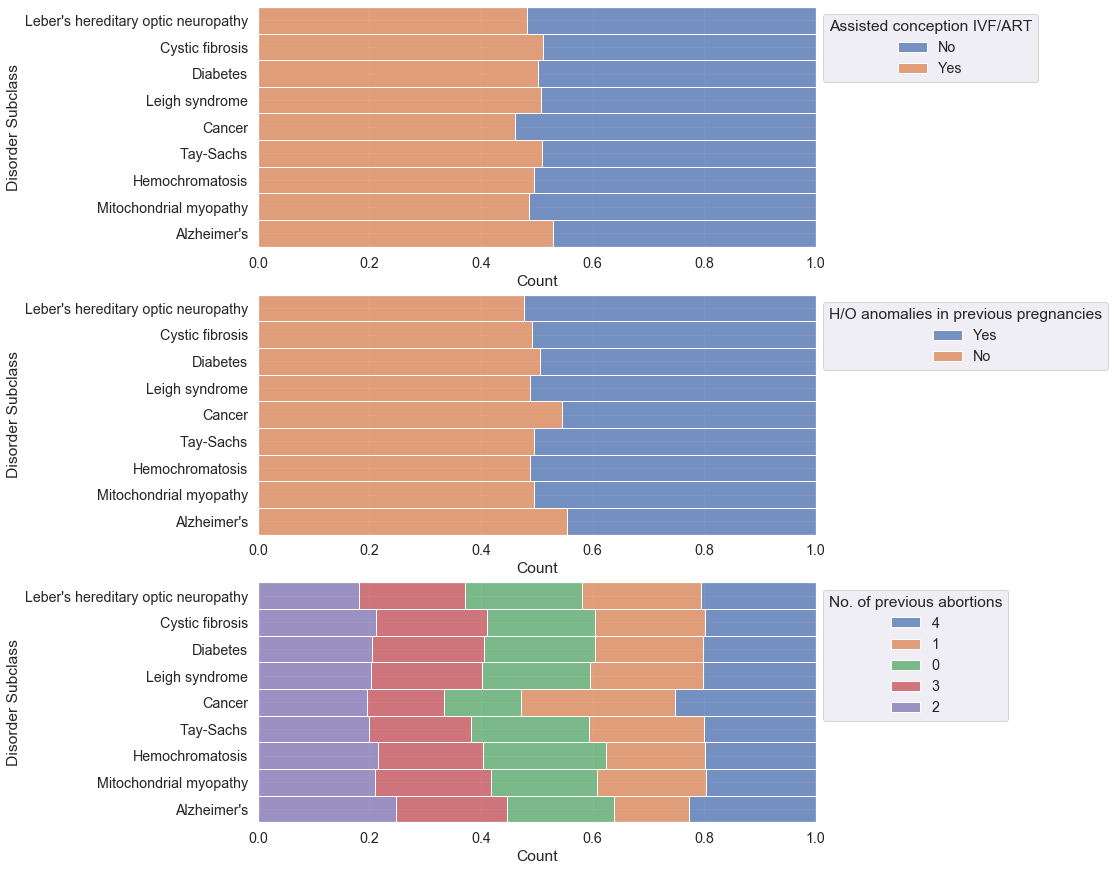

In [97]:
# Pregnancy - Disorder Subclass

SubclassDistribution(pregnancy_columns)

## Mother's health factors

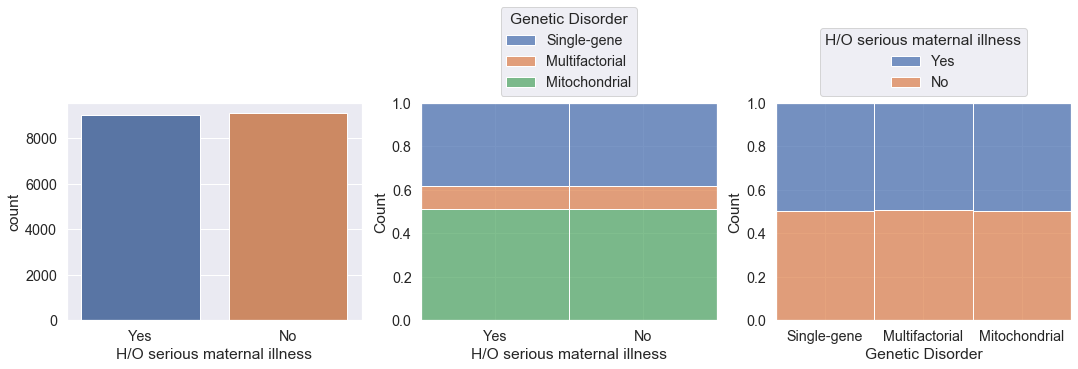

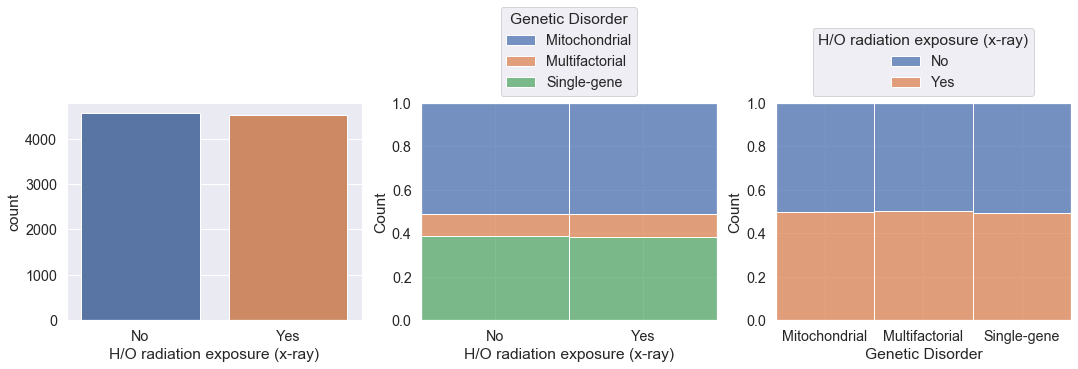

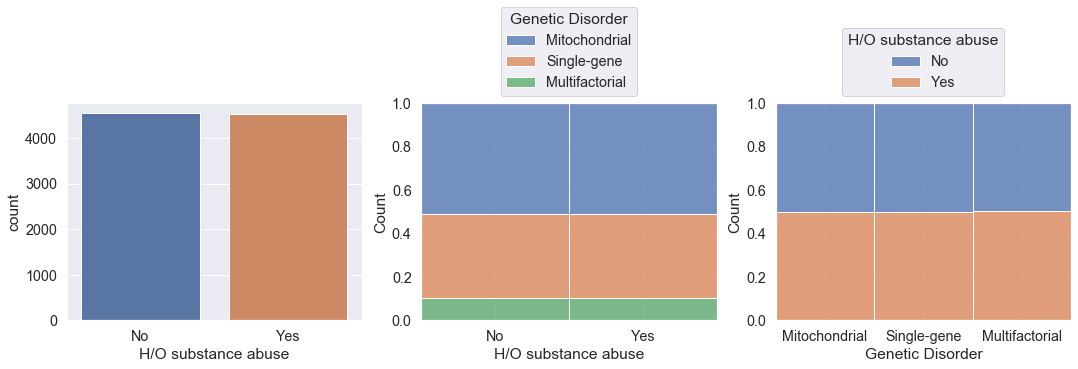

In [98]:
# Mother's health-related variables
# Mother's health - Genetic Disorder

OverallDescription(mother_health_columns)

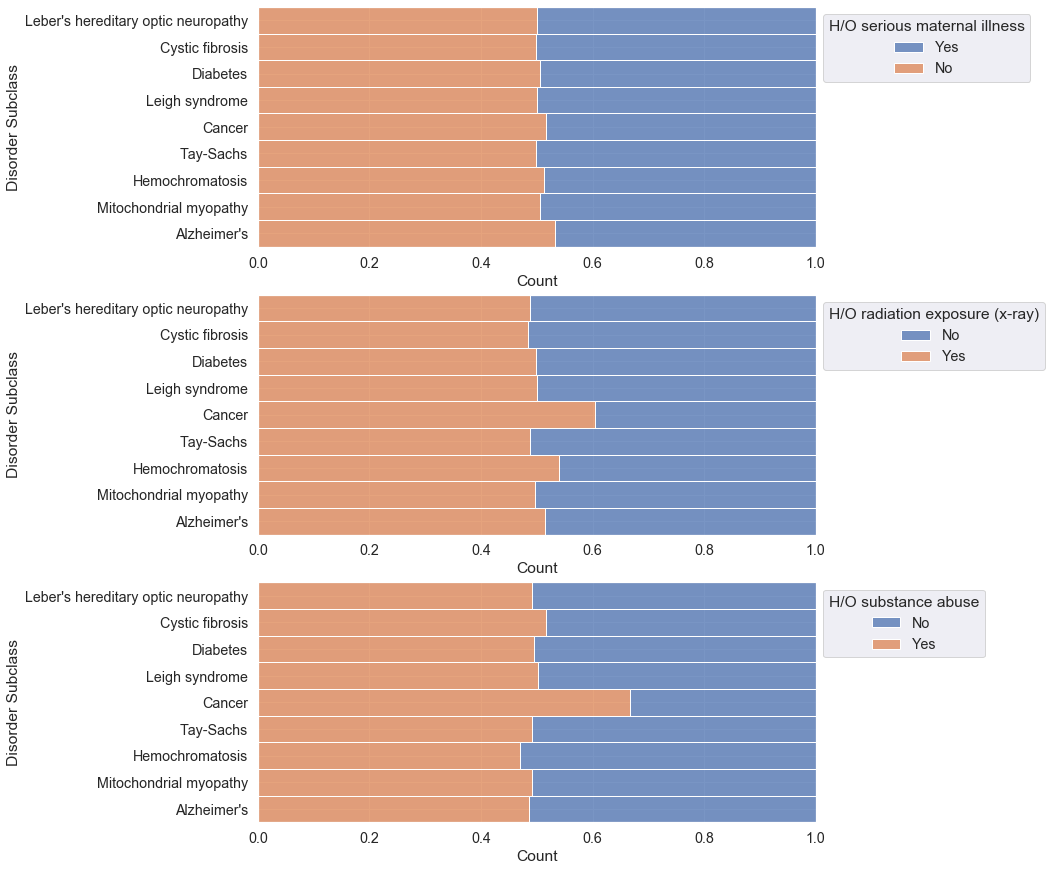

In [99]:
# Mother's health - Disorder Subclass

SubclassDistribution(mother_health_columns)

The rest of the variables, like delivery-related variables, have close to zero relationships with the response variables. All are evenly distributed and show a 50-50 distribution with regards to the response variables.

However, notable observations can be made for Cancer cases. As seen in the last 2 plots, when the mother has History of exposure to radiation and substance abuse, there is increased chance the child will get cancer. Irradiation is a known risk factor for cancer. Substance abuse, on the other hand, may or may not increase the risk of cancer, especially specific information is not available here as to what the mother has been exposed to. Nonetheless, this dataset shows increased risk of cancer for the child in this case. These cancers could be inherited from the mother or develop in the fetus during the pregnancy. The latter seems to be more likely, given the small proportion of inherited cancers seen above.

Certain variables, especially Symptoms 1-5 and Inheritance factors show trends that set multifactorial disorders apart from mitochondrial and single-gene disorders. Meanwhile, there does not seem to be any noticeable distinction between single-gene and mitochondrial disorders. Within multifactorial disorders, Cancer and Alzheimer's show clear differences from one another and from the rest of the disease subclasses. These observations may present implications on prediction of genetic disorders. For instance,  it may be easier to distinguish multifactorial disorders from the other disorder classes. On the same note, we expect some difficulties in distinguishing between single-gene and mitochondrial disorders.